<div align="center">

<img src="https://iaaa.ai/wp-content/uploads/2023/11/Final-IAAA.png" width="600" height="600">
</div>

<h1 align="center"> Variational Autoencoders </h1>
<h5 align="center">Designer & Developer: Mobin Nesari</h5>

## MNIST

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11582400.86it/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 338963.41it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3191154.05it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2001105.96it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



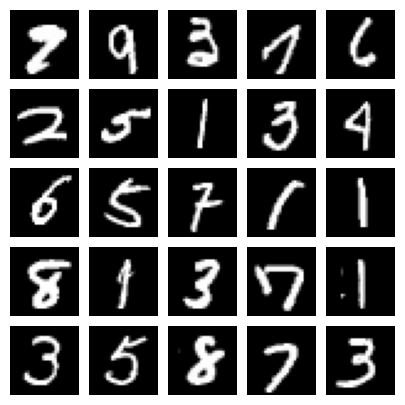

In [17]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)                     
        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))
        
        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [6]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [7]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [8]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [9]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  178.96218606531718
	Epoch 2 	Average Loss:  161.7942037510434
	Epoch 3 	Average Loss:  157.58593348940943
	Epoch 4 	Average Loss:  155.09657332533388
	Epoch 5 	Average Loss:  153.29996685556657
	Epoch 6 	Average Loss:  151.89167781263043
	Epoch 7 	Average Loss:  150.72483629943133
	Epoch 8 	Average Loss:  149.5793428663658
	Epoch 9 	Average Loss:  148.7354255138773
	Epoch 10 	Average Loss:  147.93988680678734
	Epoch 11 	Average Loss:  147.31689246074185
	Epoch 12 	Average Loss:  146.7897020261634
	Epoch 13 	Average Loss:  146.29096984557597
	Epoch 14 	Average Loss:  145.79131428357158
	Epoch 15 	Average Loss:  145.56782484153277
	Epoch 16 	Average Loss:  145.18120399233098
	Epoch 17 	Average Loss:  144.9665844115192
	Epoch 18 	Average Loss:  144.53539724410476
	Epoch 19 	Average Loss:  144.20220540092862
	Epoch 20 	Average Loss:  143.89922396702838
	Epoch 21 	Average Loss:  143.7714753104132
	Epoch 22 	Average Loss:  143.46112845954195
	Epoch 23 	Average Loss: 

8374676.5673828125

In [10]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

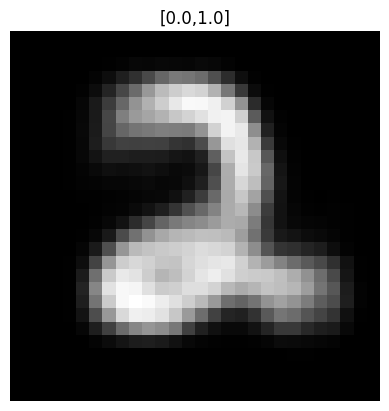

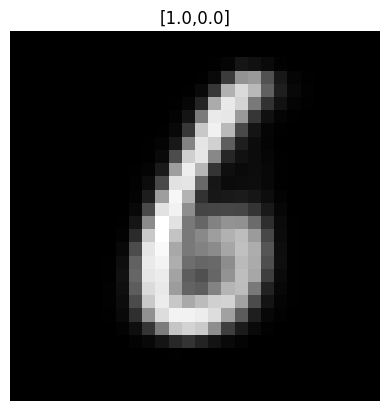

(None, None)

In [11]:
#img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [12]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

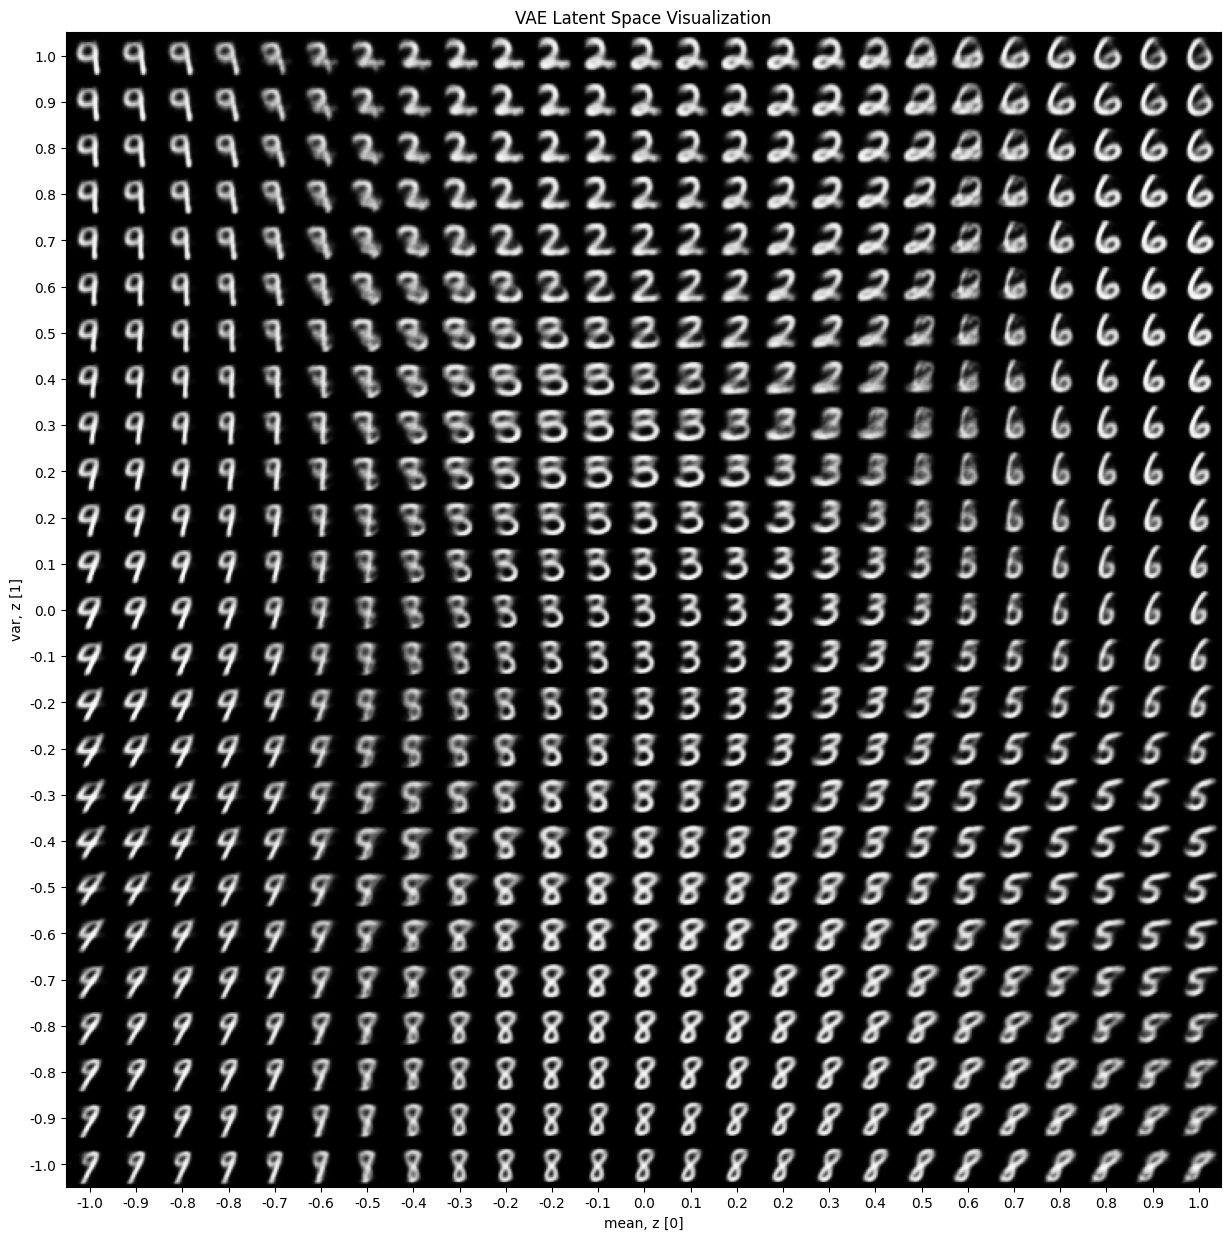

In [13]:
plot_latent_space(model, scale=1.0)

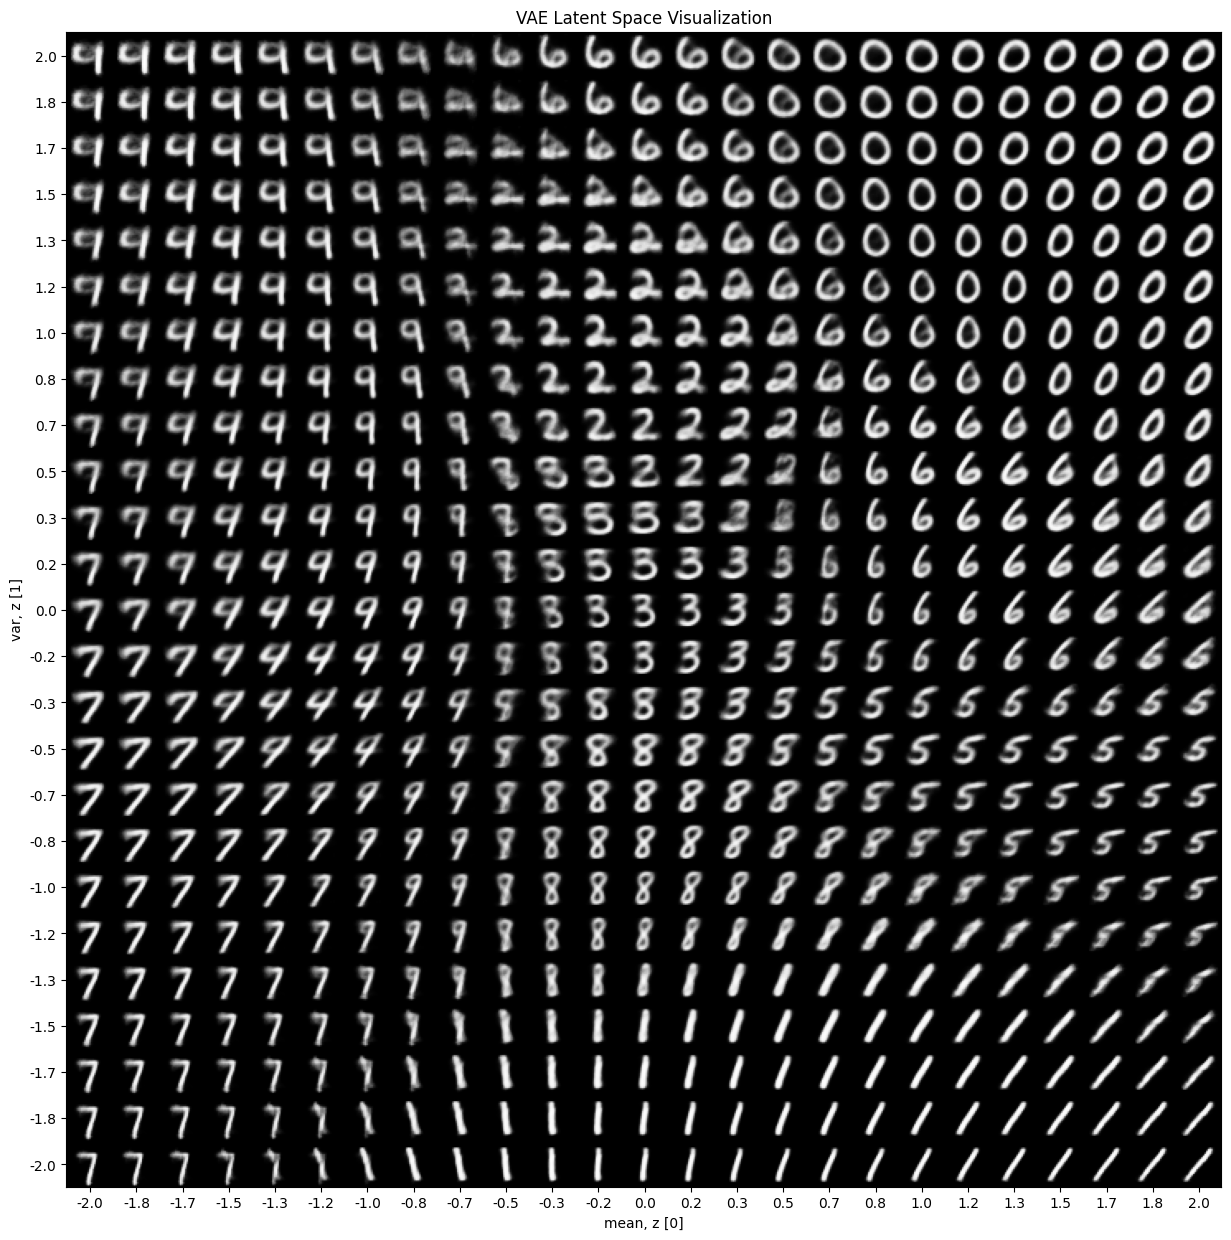

In [16]:
plot_latent_space(model, scale=2.0)

## CIFAR 10

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [5]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 512
latent_dim = 16
n_embeddings= 512
output_dim = 3
commitment_beta = 0.25

lr = 2e-4

epochs = 50

print_step = 50

In [6]:
torch.cuda.is_available()


True

In [7]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

100%|██████████| 170498071/170498071 [00:05<00:00, 29491898.78it/s]


Extracting /root/datasets/cifar-10-python.tar.gz to /root/datasets
Files already downloaded and verified


In [8]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_4, padding=0)
        
        self.proj = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        y = self.proj(y)
        return y

In [9]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [10]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.in_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):

        x = self.in_proj(x)
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [11]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity

In [12]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

In [13]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

In [14]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        
        loss =  recon_loss + commitment_loss * commitment_beta + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "(", batch_idx + 1, ") recon_loss:", recon_loss.item(), " perplexity: ", perplexity.item(), 
              " commit_loss: ", commitment_loss.item(), "\n\t codebook loss: ", codebook_loss.item(), " total_loss: ", loss.item(), "\n")
    
print("Finish!!")

Start training VQ-VAE...
epoch: 1 ( 1 ) recon_loss: 0.49078378081321716  perplexity:  32.95989990234375  commit_loss:  0.0023767503444105387 
	 codebook loss:  0.009507001377642155  total_loss:  0.500885009765625 

epoch: 1 ( 51 ) recon_loss: 0.03245531767606735  perplexity:  59.757877349853516  commit_loss:  0.02462502382695675 
	 codebook loss:  0.098500095307827  total_loss:  0.13711166381835938 

epoch: 1 ( 101 ) recon_loss: 0.020785029977560043  perplexity:  188.58407592773438  commit_loss:  0.030698517337441444 
	 codebook loss:  0.12279406934976578  total_loss:  0.15125373005867004 

epoch: 1 ( 151 ) recon_loss: 0.015209658071398735  perplexity:  220.19680786132812  commit_loss:  0.025278935208916664 
	 codebook loss:  0.10111574083566666  total_loss:  0.12264513224363327 

epoch: 1 ( 201 ) recon_loss: 0.0127777811139822  perplexity:  272.30926513671875  commit_loss:  0.024009302258491516 
	 codebook loss:  0.09603720903396606  total_loss:  0.114817313849926 

epoch: 1 ( 251 ) r

In [15]:
import matplotlib.pyplot as plt
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [16]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  418.8164367675781 commit_loss:  0.02285514771938324   codebook loss:  0.09142059087753296


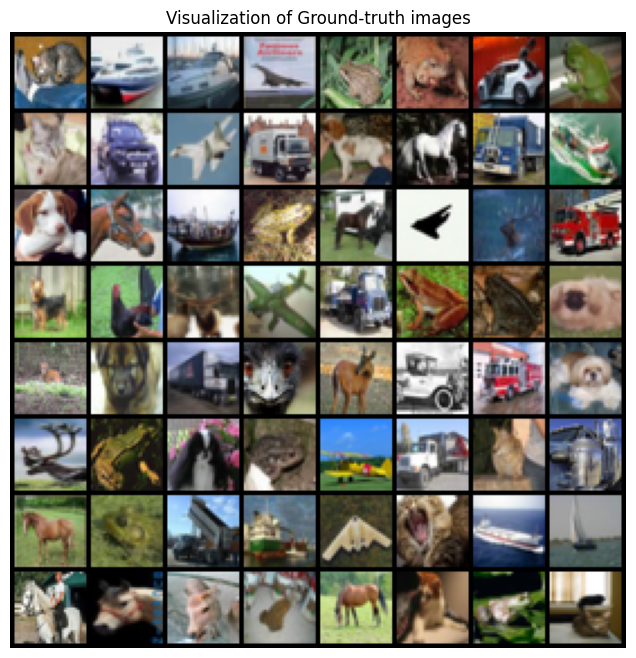

In [17]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")


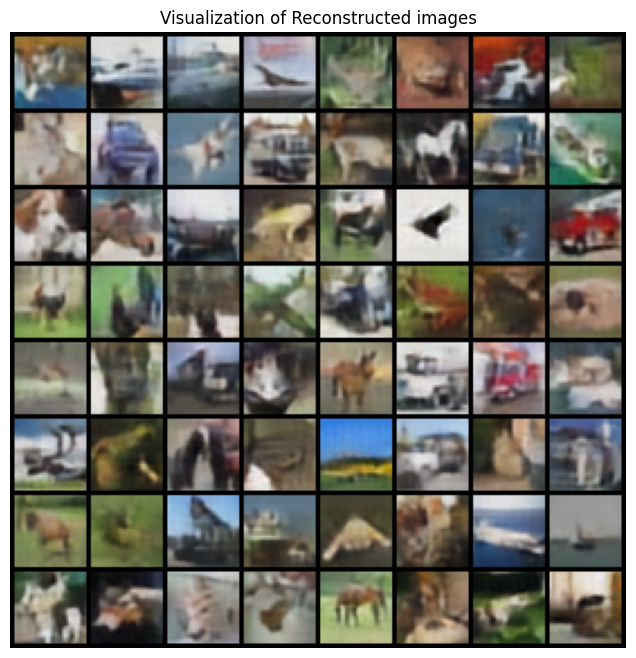

In [18]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

In [19]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

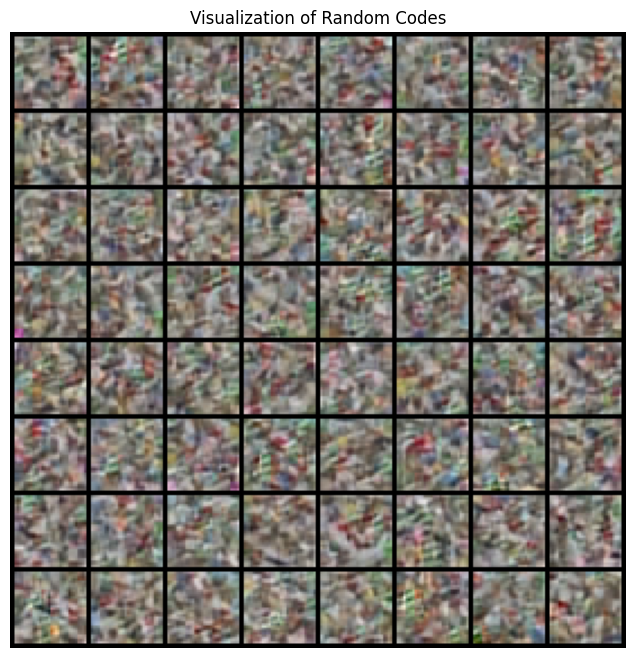

In [20]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, 8, 8))